### Overview

5 archetype users:

1: Labels consistent with image, i.e., (0, 1, 2, 3, 4) -> (0, 1, 2, 3, 4)
2: (0, 1, 2, 3, 4) -> (1, 2, 3, 4, 0)
3: (0, 1, 2, 3, 4) -> (2, 3, 4, 0, 1)
4: (0, 1, 2, 3, 4) -> (3, 4, 0, 1, 2)
5: (0, 1, 2, 3, 4) -> (4, 0, 1, 2, 3)
100 users, 20 of each type. For each user:

inputs are randomly sampled MNIST digits (0-4)
outputs are the labels of the associated archetype with probability .9, random label with probability .1
20 train examples, 20 validation, 50 test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

In [3]:
data_dir = "/data/ddmg/redditlanguagemodeling/results/mnist"

In [46]:
def collect_details(base_dir, seeds):
    collect_losses = {"loss": [], "step": [], "user": [], "seed": []}
    collect_ws = []
    collect_embeds = []
    collect_embed_grads = []
    collect_w_grads = []
    collect_users = []
    num_users = 100
    user_batch_size = 20
    for seed in seeds:
        result_dir = os.path.join(base_dir, str(seed))
        user_step_losses = np.load(os.path.join(result_dir, "step_user_losses.npy"))
        num_steps = len(user_step_losses)
        losses_flat = user_step_losses.flatten()
        collect_losses["loss"] += list(losses_flat)
        collect_losses["step"] += list(np.array([[step] * user_batch_size for step in range(num_steps)]).flatten())
        users = np.load(os.path.join(result_dir, "train_users.npy"))
        collect_losses["user"] += list(users.flatten())
        collect_losses["seed"] += [seed] * len(losses_flat)
        weight_matrices = np.load(os.path.join(result_dir, "user_weight_matrices.npy"))
        embeds = np.load(os.path.join(result_dir, "user_embeds.npy"))
        w_grads = np.load(os.path.join(result_dir, "weight_gradients.npy"))
        embeds_grads = np.load(os.path.join(result_dir, "user_embeds_gradients.npy"))
        collect_ws.append(weight_matrices)
        collect_embeds.append(embeds)
        collect_w_grads.append(w_grads)
        collect_embed_grads.append(embeds_grads)
        collect_users.append(users)
    return collect_losses, collect_ws, collect_embeds, collect_w_grads, collect_embed_grads, collect_users

In [9]:
def collect_results_single_param(base_dir, seeds):
    collect_results = []
    for seed in seeds:
        result_dir = os.path.join(base_dir, str(seed))
        with open(os.path.join(result_dir, "test_results.json"), "rb") as f:
            results = json.load(f)
        num_users = 100
        for user in range(num_users):
            user_acc = results[str(user)]["test_accuracy"]
            collect_results.append({"user": user, "accuracy": user_acc, "seed": seed})
    result_df = pd.DataFrame(collect_results)
    return result_df

In [6]:
def collect_train_times(base_dir, seeds):
    times = []
    sps = []
    for seed in seeds:
        result_dir = os.path.join(base_dir, str(seed))
        with open(os.path.join(result_dir, "trainer_state.json"), "rb") as f:
            t_state = json.load(f)
        times.append(t_state["log_history"][-1]["train_runtime"])
        sps.append(t_state["log_history"][-1]["train_samples_per_second"])
    return times, sps

In [10]:
results = collect_results_single_param(os.path.join(data_dir, "5_archetype_users_test1"), [42])

In [11]:
results

,user,accuracy,seed
0,0,0.2600,42
1,1,0.0800,42
2,2,0.1400,42
3,3,0.2576,42
4,4,0.2400,42
...,...,...,...
95,95,0.3000,42
96,96,0.2000,42
97,97,0.2200,42
98,98,0.2184,42


In [12]:
print(results["accuracy"].mean(), results["accuracy"].std())

0.20483199939131735 0.051021331957301234


In [13]:
times, sps = collect_train_times(os.path.join(data_dir, "5_archetype_users_test1"), [42])

In [14]:
times

[29625.8011]

In [16]:
29625 / (60 * 60)

8.229166666666666

In [47]:
loss, weights, embeds, weight_grads, embeds_grads, train_users = collect_details(os.path.join(data_dir, "5_archetype_users_test1"), [42])

In [38]:
train_users[0][:69].flatten()

array([83., 53., 70., ...,  4., 48., 10.])

In [39]:
len(loss['step'])

4000

In [48]:
loss_df = pd.DataFrame(loss)

In [50]:
loss_df = loss_df[loss_df["step"] < 69]
loss_df

,loss,step,user,seed
0,1.601677,0,83.0,42
1,1.608793,0,53.0,42
2,1.604948,0,70.0,42
3,1.611738,0,45.0,42
4,1.610108,0,44.0,42
...,...,...,...,...
1375,1.589681,68,19.0,42
1376,1.614654,68,36.0,42
1377,1.612467,68,4.0,42
1378,1.602234,68,48.0,42


<AxesSubplot:xlabel='step', ylabel='loss'>

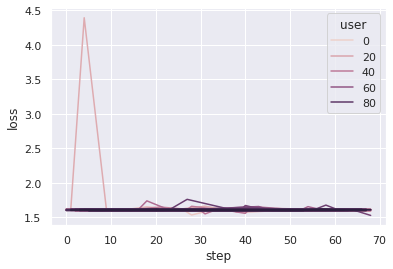

In [51]:
sns.lineplot(data=loss_df, x="step", y="loss", hue="user")

In [52]:
weights[0][:69]

array([[[[ 5.        ,  5.        ,  5.        , ...,  5.        ,
           5.        ,  5.        ],
         [ 5.        ,  5.        ,  5.        , ...,  5.        ,
           5.        ,  5.        ],
         [ 5.        ,  5.        ,  5.        , ...,  5.        ,
           5.        ,  5.        ],
         ...,
         [ 5.        ,  5.        ,  5.        , ...,  5.        ,
           5.        ,  5.        ],
         [ 5.        ,  5.        ,  5.        , ...,  5.        ,
           5.        ,  5.        ],
         [ 5.        ,  5.        ,  5.        , ...,  5.        ,
           5.        ,  5.        ]],

        [[ 4.90051126,  4.90056562,  4.99947262, ...,  4.99931717,
           4.90058088,  4.99946022],
         [ 4.90056562,  4.90061998,  4.99952793, ...,  4.99937296,
           4.90063524,  4.99951553],
         [ 4.99947262,  4.99952793,  5.1004324 , ...,  5.10027409,
           4.99954367,  5.10042   ],
         ...,
         [ 4.99931717,  4.99937296

In [54]:
embeds[0][:69]

array([[[[1.        , 1.        , 1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        , 1.        , 1.        ]],

        [[0.99000114, 0.99000114, 0.99000114, 0.99000114, 0.99000114],
         [0.99001211, 0.99001211, 0.99001211, 0.99001211, 0.99001211],
         [1.00999331, 1.00999331, 1.00999331, 1.00999331, 1.00999331],
         ...,
         [1.00996196, 1.00996196, 1.00996196, 1.00996196, 1.00996196],
         [0.99001521, 0.99001521, 0.99001521, 0.99001521, 0.99001521],
         [1.00999081, 1.00999081, 1.00999081, 1.00999081, 1.00999081]],

        [[0.98401886, 0.98401886, 0.98401886, 0.98401886, 0.98401886],
         [0.98109055, 0.98109055, 0.98109055,

In [61]:
weight_grads[0][:69][0][0][83]

array([ 8.75817277e-05,  8.22990387e-06, -1.49029902e-05, -1.24521730e-05,
        9.49954119e-06,  4.48545779e-06, -1.16984902e-05,  1.82017016e-06,
       -2.65886911e-06, -3.65875536e-07, -2.17235556e-05, -2.70116743e-06,
        6.49444837e-06,  1.54378267e-05, -5.06778815e-06, -8.72776582e-07,
        1.01465384e-05,  5.30416719e-06, -4.12971394e-06,  1.07045616e-05,
       -3.60887543e-06,  7.91813181e-06, -7.38137260e-06,  5.59057207e-06,
        1.58264356e-07, -1.32065688e-05, -5.48646722e-06, -8.01026181e-06,
        5.02718740e-06,  1.27393841e-05,  3.59222071e-07,  1.07188671e-05,
       -6.28997213e-06, -3.35798109e-06, -8.52011090e-06, -4.68976123e-06,
        5.62039349e-06, -4.76224977e-06, -3.08423228e-06,  2.46870713e-05,
       -2.26344469e-06, -1.55987584e-06, -2.06956565e-06,  1.55048542e-06,
        2.05297192e-06,  2.75915409e-06,  1.58470027e-06,  7.07625668e-06,
       -6.47084516e-06,  8.60265573e-06, -3.48853723e-06, -1.04173505e-05,
       -3.68996916e-06, -

In [62]:
embeds_grads

[array([[[[ 8.75817277e-05,  8.75817277e-05,  8.75817277e-05,
            8.75817277e-05,  8.75817277e-05],
          [ 8.22990387e-06,  8.22990387e-06,  8.22990387e-06,
            8.22990387e-06,  8.22990387e-06],
          [-1.49029902e-05, -1.49029902e-05, -1.49029902e-05,
           -1.49029902e-05, -1.49029902e-05],
          ...,
          [-2.61950026e-06, -2.61950026e-06, -2.61950026e-06,
           -2.61950026e-06, -2.61950026e-06],
          [ 6.57433839e-06,  6.57433839e-06,  6.57433839e-06,
            6.57433839e-06,  6.57433839e-06],
          [-1.08633922e-05, -1.08633922e-05, -1.08633922e-05,
           -1.08633922e-05, -1.08633922e-05]],
 
         [[-8.13520364e-06, -8.13520364e-06, -8.13520364e-06,
           -8.13520364e-06, -8.13520364e-06],
          [ 3.06040820e-05,  3.06040820e-05,  3.06040820e-05,
            3.06040820e-05,  3.06040820e-05],
          [ 2.24811538e-05,  2.24811538e-05,  2.24811538e-05,
            2.24811538e-05,  2.24811538e-05],
          

In [57]:
train_users[0][:69]

array([[83., 53., 70., ..., 77., 12., 31.],
       [79., 37., 65., ..., 30., 16., 49.],
       [48., 28., 85., ..., 40., 13., 61.],
       ...,
       [14., 91., 48., ..., 67., 98., 12.],
       [45., 27., 72., ..., 36., 96., 49.],
       [74., 23., 59., ...,  4., 48., 10.]])